In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext lab_black
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import os
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K
from tensorflow.keras.layers import GaussianNoise
from helpers import *

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2
from tensorflow.compat.v2.keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [3]:
np.random.seed(8)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14422392345796079315
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4937233203
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10895966127995085386
physical_device_desc: "device: 0, name: GeForce GTX 1060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Loading images

In [4]:
image_dir_train = "data/training/images/"
files = os.listdir(image_dir_train)
n_train = len(files)
print(f"Loading training images, images loaded: {n_train} ")
imgs_train = np.asarray(
    [load_image(image_dir_train + files[i]) for i in range(n_train)]
)
gt_dir_train = "data/training/groundtruth/"
print(f"Loading groundtruth images, images loaded: {n_train} ")
gt_imgs_train = np.asarray(
    [load_image(gt_dir_train + files[i]) for i in range(n_train)]
)

Loading training images, images loaded: 80 
Loading groundtruth images, images loaded: 80 


In [5]:
imgs_train.shape

(80, 400, 400, 3)

In [6]:
gt_imgs_train.shape

(80, 400, 400)

In [7]:
image_size = 400
# Patches for training
img_patches_train = [
    crop_image(imgs_train[i], image_size, image_size) for i in range(n_train)
]
gt_patches_train = [
    crop_image(gt_imgs_train[i], image_size, image_size) for i in range(n_train)
]

# Separate features and labels
X_train = np.asarray(
    [
        img_patches_train[i][j]
        for i in range(len(img_patches_train))
        for j in range(len(img_patches_train[i]))
    ]
)
Y_train = np.asarray(
    [
        gt_patches_train[i][j]
        for i in range(len(gt_patches_train))
        for j in range(len(gt_patches_train[i]))
    ]
)

In [8]:
X_train.shape

(80, 400, 400, 3)

In [9]:
Y_train.shape

(80, 400, 400)

In [10]:
image_dir_val = "data/validating/images/"
files = os.listdir(image_dir_val)
n_val = len(files)
print(f"Loading validating images, images loaded: {n_val} ")
imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])
gt_dir_val = "data/validating/groundtruth/"
print(f"Loading validating groundtruth, images loaded: {n_val} ")
gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

Loading validating images, images loaded: 20 
Loading validating groundtruth, images loaded: 20 


In [11]:
imgs_val.shape

(20, 400, 400, 3)

In [12]:
gt_imgs_val.shape

(20, 400, 400)

In [13]:
image_size = 400
# Patches for validating
img_patches_val = [
    crop_image(imgs_val[i], image_size, image_size) for i in range(n_val)
]
gt_patches_val = [
    crop_image(gt_imgs_val[i], image_size, image_size) for i in range(n_val)
]

# Separate features and labels
X_val = np.asarray(
    [
        img_patches_val[i][j]
        for i in range(len(img_patches_val))
        for j in range(len(img_patches_val[i]))
    ]
)
Y_val = np.asarray(
    [
        gt_patches_val[i][j]
        for i in range(len(gt_patches_val))
        for j in range(len(gt_patches_val[i]))
    ]
)

In [14]:
X_val.shape

(20, 400, 400, 3)

In [15]:
Y_val.shape

(20, 400, 400)

In [16]:
X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [17]:
X_train = np.asarray(X_train)
Y_train = np.asarray(Y_train)

In [18]:
print(X_train.shape)
print(Y_train.shape)
n_train = Y_train.shape[0]

(720, 456, 456, 3)
(720, 456, 456)


In [19]:
X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [20]:
X_val = np.asarray(X_val)
Y_val = np.asarray(Y_val)

In [21]:
print(X_val.shape)
print(Y_val.shape)
n_val = Y_val.shape[0]

(180, 456, 456, 3)
(180, 456, 456)


# Create functions to calcualte precision, recall and F-1 in the training of model

In [22]:
def precision(y_true, y_pred):
    """Compute the Precision for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
        Precision (numpy.float64): the Precision of the batch 
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Compute the Recall for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       Recall (numpy.float64): the Recal of the batch 
    """

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    """Compute the F-1 for the batch.
    Args:
        y_true (numpy.ndarray): the ground truth labels
        y_pred (numpy.ndarray): the predicted labels 
    Returns:
       F-1 (numpy.float64): the F-1 of the batch 
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

# U-Net Architecture

In [23]:
def down(input_layer, filters, pool=True):
    """Create convloutional and residual layers to reduce dimensions.
    Args:
        input_layer (layer): input layer before convolution
        filters (numpy.int64): number of filters
    Returns:
        max_pool (layer): layer after max-pooling
        residual (connection ): connection to connect with next layers
    """
    batchnorm = BatchNormalization()(input_layer)
    conv1 = Conv2D(filters, (5, 5), padding="same", activation="relu")(batchnorm)
    residual = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual


def up(input_layer, residual, filters):
    """Create convloutional and residual layers to increase dimensions.
    Args:
        input_layer (layer): input layer before convolution\
        residual (connection ): connection to connect with next layers
        filters (numpy.int64): number of filters
    Returns:
        conv2 (layer): convolutional layer
    """
    filters = int(filters)
    batchnorm = BatchNormalization()(input_layer)
    upsample = UpSampling2D()(batchnorm)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (5, 5), padding="same", activation="relu")(concat)
    conv2 = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
    return conv2


class U_NET:
    def __init__(self, shape):
        self.shape = shape
        self.model = self.initialize_U_NET(shape)

    def initialize_U_NET(self, shape):
        """Create Network Architecture.
        Args:
            shape (triplet): Size of the input layer height x width x colors (64 x 64 x 3)
        Returns:
            model (Neural Network): Architecture of the model
        """
        # Make a custom U-nets implementation.
        filters = 64
        input_layer = Input(shape=shape)
        layers = [input_layer]
        residuals = []

        # Down 1, 64
        d1, res1 = down(input_layer, filters)
        residuals.append(res1)
        filters *= 2

        # Down 2, 32
        d2, res2 = down(d1, filters)
        residuals.append(res2)
        filters *= 2

        # Down 3, 16
        d3, res3 = down(d2, filters)
        residuals.append(res3)
        filters *= 2

        # Down 4, 8
        d4, res4 = down(d3, filters)
        residuals.append(res4)
        filters *= 2

        # Up 1, 8
        up1 = up(d4, residual=residuals[-1], filters=filters / 2)
        filters /= 2

        # Up 2,  16
        up2 = up(up1, residual=residuals[-2], filters=filters / 2)
        filters /= 2

        # Up 3, 32
        up3 = up(up2, residual=residuals[-3], filters=filters / 2)
        filters /= 2

        # Up 4, 64
        up4 = up(up3, residual=residuals[-4], filters=filters / 2)

        conv_1 = Conv2D(1, 1, activation="relu")(up4)
        flaten = Flatten()(conv_1)
        batch_1 = BatchNormalization()(flaten)
        out = Dense(
            2,
            activation="sigmoid",
            kernel_regularizer=l2(0.00001),
            activity_regularizer=l2(0.00001),
        )(batch_1)
        #         flaten = Flatten()(up4)
        #         batch_1 = BatchNormalization()(flaten)
        #         dense1 = Dense(
        #             64,
        #             activation="relu",
        #             kernel_regularizer=l2(0.00001),
        #             activity_regularizer=l2(0.00001),
        #         )(flaten)
        #         batch_2 = BatchNormalization()(dense1)
        #         out = Dense(
        #             2,
        #             activation="sigmoid",
        #             kernel_regularizer=l2(0.00001),
        #             activity_regularizer=l2(0.00001),
        #         )(batch_2)

        model = Model(input_layer, out)
        model.compile(
            loss="binary_crossentropy",
            optimizer=Adam(learning_rate=0.001),
            metrics=["accuracy", recall, f1],
        )

        # Print a summary of the model to see what has been generated
        model.summary()

        return model

    def train(self):
        """Train the Model.

        Returns:
            History (History_Keras): History of the training
        """
        # Early stopping callback after 10 steps
        early_stopping = EarlyStopping(
            monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True,
        )
        # Reduce learning rate on plateau after 4 steps
        lr_callback = ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=0.2,
            patience=5,
            verbose=1,
            mode="max",
            cooldown=1,
        )
        save_best = ModelCheckpoint(
            "Unet_batchnorm-{epoch:03d}-{f1:03f}-{val_f1:03f}.h5",
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        )
        callbacks = [lr_callback, save_best, early_stopping]

        # Train the model using the previously defined functions and callbacks
        history = self.model.fit_generator(
            create_minibatch(
                X_train, Y_train, n_train, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE
            ),
            steps_per_epoch=STEPS_PER_EPOCH,
            epochs=EPOCHS,
            use_multiprocessing=False,
            workers=1,
            callbacks=callbacks,
            verbose=1,
            validation_data=create_minibatch(
                X_val, Y_val, n_val, WINDOW_SIZE, BATCH_SIZE, PATCH_SIZE
            ),
            validation_steps=STEPS_PER_EPOCH / 3,
        )
        return history

    def classify(self, X):
        """Classify Image as either road or not.
        Args:
            X (image): part of the image to classify
        Returns:
            Predictions : Predictions for each patch
        """
        # Subdivide the images into blocks with a stride and patch_size of 16
        img_patches = create_patches(X, 16, 16, padding=24)

        # Predict
        predictions = self.model.predict(img_patches)
        predictions = (predictions[:, 0] < predictions[:, 1]) * 1

        # Regroup patches into images
        return predictions.reshape(X.shape[0], -1)

    #         return group_patches(predictions, X.shape[0])

    def load(self, filename):
        """Loads Saved Model.
        Args:
           filename (string): name of the model
           
        """
        # Load the model (used for submission)
        dependencies = {
            "recall": recall,
            "f1": f1,
        }
        self.model = load_model(filename, custom_objects=dependencies)

    def save(self, filename):
        """Saves trained model.
        Args:
           filename (string): name of the model
           
        """
        self.model.save(filename)

In [24]:
# We define parameters of the model
BATCH_SIZE = 150
WINDOW_SIZE = 64
PATCH_SIZE = 16
EPOCHS = 300
STEPS_PER_EPOCH = 100
model = U_NET(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   4864        batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
______________________________________________________________________________________________

# Train the Model


In [25]:
history = model.train()

Epoch 1/300
 99/100 [============================>.] - ETA: 1s - loss: 0.5229 - accuracy: 0.7352 - recall: 0.7312 - f1: 0.7318
Epoch 00001: val_accuracy improved from -inf to 0.74588, saving model to Unet_batchnorm-001-0.732424-0.745883.h5
100/100 [==============================] - 165s 2s/step - loss: 0.5223 - accuracy: 0.7357 - recall: 0.7317 - f1: 0.7324 - val_loss: 3.1219 - val_accuracy: 0.7459 - val_recall: 0.7459 - val_f1: 0.7459
Epoch 2/300
 99/100 [============================>.] - ETA: 1s - loss: 0.3940 - accuracy: 0.8070 - recall: 0.8056 - f1: 0.8067
Epoch 00002: val_accuracy did not improve from 0.74588
100/100 [==============================] - 151s 2s/step - loss: 0.3935 - accuracy: 0.8072 - recall: 0.8057 - f1: 0.8068 - val_loss: 1.0955 - val_accuracy: 0.7390 - val_recall: 0.7390 - val_f1: 0.7390
Epoch 3/300
 99/100 [============================>.] - ETA: 1s - loss: 0.3812 - accuracy: 0.8168 - recall: 0.8169 - f1: 0.8168
Epoch 00003: val_accuracy did not improve from 0.74

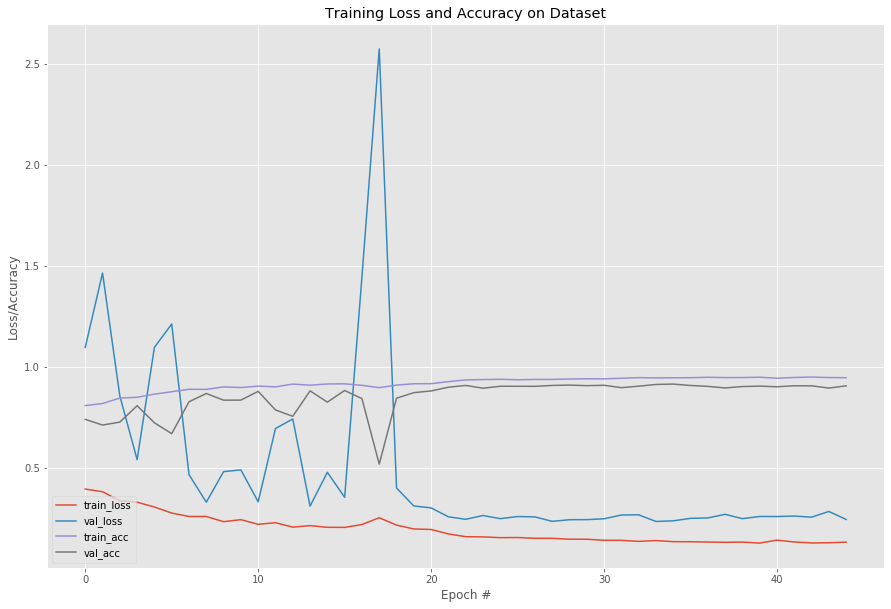

In [26]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"][1:], label="train_loss")
plt.plot(history.history["val_loss"][1:], label="val_loss")
plt.plot(history.history["accuracy"][1:], label="train_acc")
plt.plot(history.history["val_accuracy"][1:], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("Unet_batchnorm.png")
plt.show()

In [63]:
# Instantiate the model
model = U_NET(shape=(WINDOW_SIZE, WINDOW_SIZE, 3))

# Load the model
model.load("Unet_batchnorm-036-0.944867-0.913723.h5")

model.model.summary()

# We add all test images to an array, used later for generating a submission
image_filenames = []
for i in range(1, 51):
    image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
    image_filenames.append(image_filename)

# Set-up submission filename
submission_filename = "Unet_batchnorm-036-0.944867-0.913723.csv"

# Generates the submission
generate_submission(model, submission_filename, *image_filenames)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 64, 64, 3)    12          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 64, 64, 64)   4864        batch_normalization_9[0][0]      
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_21[0][0]                  
____________________________________________________________________________________________

In [28]:
# # Load a set of images
# root_dir = "data/training/"

# # Select the directory for the images and load them
# image_dir = root_dir + "images/"
# files = os.listdir(image_dir)
# n = len(files)

# print("Loading " + str(n) + " images")
# imgs = np.asarray([load_image(image_dir + files[i]) for i in range(n)])

# # Select the directory for groundtruth images and load them
# gt_dir = root_dir + "groundtruth/"
# print("Loading " + str(n) + " groundtruth images")
# gt_imgs = np.asarray([load_image(gt_dir + files[i]) for i in range(n)])

In [29]:
# image_size = 400

# # We separate the images from the groundtruth images
# img_patches = [img_crop(imgs[i], image_size, image_size) for i in range(n)]
# gt_patches = [img_crop(gt_imgs[i], image_size, image_size) for i in range(n)]

# # Linearize the list and labeling them X and Y
# X = np.asarray(
#     [
#         img_patches[i][j]
#         for i in range(len(img_patches))
#         for j in range(len(img_patches[i]))
#     ]
# )
# Y = np.asarray(
#     [
#         gt_patches[i][j]
#         for i in range(len(gt_patches))
#         for j in range(len(gt_patches[i]))
#     ]
# )

In [30]:
# def create_minibatch():

#     # Fix the seed
#     np.random.seed(1)

#     # We define the window size of 72, batch size of 100 (empirically chosen)
#     # and patch size should correspond to 16
#     w_size = 72
#     batch_size = 100
#     patch_size = 16
#     num_images = 100

#     while True:
#         # Generate one minibatch
#         batch_image = np.empty((batch_size, w_size, w_size, 3))
#         batch_label = np.empty((batch_size, 2))

#         for i in range(batch_size):

#             # Select a random index represnting an image
#             random_index = np.random.choice(num_images)

#             # Width of original image
#             width = 400

#             # Sample a random window from the image
#             random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

#             # Create a sub image of size 72x72
#             sampled_image = X[random_index][
#                 random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
#                 random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
#             ]

#             # Take its corresponding ground-truth image
#             correspond_ground_truth = Y[random_index][
#                 random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
#                 random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
#             ]

#             # We set in the label depending on the threshold of 0.2
#             # The label becomes either 0 or 1 by applying to_categorical with parameter 2
#             label = to_categorical(
#                 (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
#             )

#             # The image augmentation is based on both flipping and rotating (randomly in steps of 45°)
#             # Random vertical and horizontal flip
#             if np.random.choice(2) == 1:
#                 sampled_image = np.flipud(sampled_image)

#             if np.random.choice(2) == 1:
#                 sampled_image = np.fliplr(sampled_image)

#             # Random rotation in steps of 45°
#             rotations = [0, 45, 90, 135, 180, 225, 270, 315, 350]

#             # We select a rotation degree randomly
#             rotation_choice = np.random.choice(len(rotations))

#             # Rotate it using the random value (uses the scipy library)
#             sampled_image = scipy.ndimage.rotate(
#                 sampled_image,
#                 rotations[rotation_choice],
#                 order=1,
#                 reshape=False,
#                 mode="reflect",
#             )

#             # We put in the sub image and its corresponding label before yielding it
#             batch_image[i] = sampled_image
#             batch_label[i] = label

#         # Yield the mini_batch to the model
#         yield (batch_image, batch_label)

In [31]:
# def down(input_layer, filters, pool=True):
#     conv1 = Conv2D(filters, (3, 3), padding="same", activation="relu")(input_layer)
#     residual = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
#     if pool:
#         max_pool = MaxPool2D()(residual)
#         return max_pool, residual
#     else:
#         return residual


# def up(input_layer, residual, filters):
#     filters = int(filters)
#     upsample = UpSampling2D()(input_layer)
#     upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
#     concat = Concatenate(axis=3)([residual, upconv])
#     conv1 = Conv2D(filters, (3, 3), padding="same", activation="relu")(concat)
#     conv2 = Conv2D(filters, (3, 3), padding="same", activation="relu")(conv1)
#     return conv2


# class cnn_model:

#     # Initialize the class
#     def __init__(self, shape, batch_normalization, activation):
#         self.shape = shape
#         self.batch_normalization = batch_normalization
#         self.activation = activation
#         self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

#     def initialize_cnn_model(self, shape, batch_normalization, activation):
#         # Make a custom U-nets implementation.
#         filters = 64
#         input_layer = Input(shape=[128, 128, 3])
#         layers = [input_layer]
#         residuals = []

#         # Down 1, 128
#         d1, res1 = down(input_layer, filters)
#         residuals.append(res1)
#         filters *= 2

#         # Down 2, 64
#         d2, res2 = down(d1, filters)
#         residuals.append(res2)
#         filters *= 2

#         # Down 3, 32
#         d3, res3 = down(d2, filters)
#         residuals.append(res3)
#         filters *= 2

#         # Down 4, 16
#         d4, res4 = down(d3, filters)
#         residuals.append(res4)
#         filters *= 2

#         # Down 5, 8
#         d5 = down(d4, filters, pool=False)

#         # Up 1, 16
#         up1 = up(d5, residual=residuals[-1], filters=filters / 2)
#         filters /= 2

#         # Up 2,  32
#         up2 = up(up1, residual=residuals[-2], filters=filters / 2)
#         filters /= 2

#         # Up 3, 64
#         up3 = up(up2, residual=residuals[-3], filters=filters / 2)
#         filters /= 2

#         # Up 4, 128
#         up4 = up(up3, residual=residuals[-4], filters=filters / 2)
#         out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

#         model = Model(input_layer, out)
#         model.compile(
#             loss="binary_crossentropy",
#             optimizer=Adam(lr=0.001),
#             metrics=["accuracy", recall, f1],
#         )

#         # Print a summary of the model to see what has been generated
#         model.summary()

#         return model

#     def train(self):

#         # Early stopping callback after 10 steps
#         early_stopping = EarlyStopping(
#             monitor="f1", min_delta=0.5, patience=20, verbose=0, mode="max"
#         )

#         # Reduce learning rate on plateau after 4 steps
#         lr_callback = ReduceLROnPlateau(
#             monitor="f1", factor=0.5, patience=4, verbose=0, mode="max"
#         )

#         # Place the callbacks in a list to be used when training
#         #         callbacks = [cb, early_stopping, lr_callback]
#         save_best = ModelCheckpoint(
#             "batch_relu_OLD_Ali_amsgrad_noise-{epoch:03d}-{f1:03f}.h5",
#             save_best_only=True,
#             monitor="f1",
#             mode="max",
#             verbose=1,
#         )

#         callbacks = [lr_callback, save_best]

#         # Train the model using the previously defined functions and callbacks
#         history = self.model.fit_generator(
#             create_minibatch(),
#             steps_per_epoch=STEPS_PER_EPOCH,
#             epochs=EPOCHS,
#             use_multiprocessing=False,
#             workers=1,
#             callbacks=callbacks,
#             verbose=1,
#         )

#         return history

#     def classify(self, X):
#         # Subdivide the images into blocks with a stride and patch_size of 16
#         img_patches = create_patches(X, 16, 16, padding=28)

#         # Predict
#         predictions = self.model.predict(img_patches)
#         predictions = (predictions[:, 0] < predictions[:, 1]) * 1

#         # Regroup patches into images
#         return group_patches(predictions, X.shape[0])

#     def load(self, filename):
#         # Load the model (used for submission)
#         dependencies = {
#             "recall": recall,
#             "f1": f1,
#         }
#         self.model = load_model(filename, custom_objects=dependencies)

#     def save(self, filename):
#         # Save the model (used to then load to submit)
#         self.model.save(filename)

In [32]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# EPOCHS = 120
# STEPS_PER_EPOCH = 150
# batch_normalization = True
# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# history = model.train()
# model.save("batch_relu_OLD_Ali_amsgrad_noise.h5")

In [33]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# # plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["accuracy"], label="train_acc")
# # plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_relu_OLD_Ali_amsgrad_noise.png")
# plt.show()

In [34]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load("batch_relu_OLD_Ali_amsgrad_noise-092-0.952039.h5")

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = "batch_relu_OLD_Ali_amsgrad_noise-092-0.952039.csv"

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)

In [35]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# # We define the number of epochs and steps per epochs
# EPOCHS = 160
# STEPS_PER_EPOCH = 150
# batch_normalization = True
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model
# history = model.train()
# # model.save("no_batch_LeakyRelu_validation_1.h5")

In [36]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_LeakyReLU_validation_160_dropout-0.2.png")
# plt.show()

In [37]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load(
#     "saved_models/batch_LeakyReLU_validation_160_dropout-0.2-070-0.948567-0.928000.h5"
# )

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = "to_submit_csv/batch_LeakyReLU_validation_160_dropout-0.2-070-0.948567-0.928000.csv"

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)

In [38]:
# # history.history["loss"]
# print(history.history.keys())

In [39]:
# plt.plot(history.history["accuracy"])
# plt.plot(history.history["val_accuracy"])
# plt.title("model accuracy")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(["train", "val"], loc="upper left")
# plt.show()

In [40]:
# # plot the training loss and accuracy
# N = EPOCHS
# print(N)
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
# plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
# plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.show()
# plt.savefig("model1.png")

In [41]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = False
# EPOCHS = 200

# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# model.train()
# model.save("no_batch_relu_validation.h5")

In [42]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 200

# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# model.train()
# model.save("batch_LeakyReLU_validation.h5")

In [43]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 200
# STEPS_PER_EPOCH = 150
# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# history = model.train()
# # model.save("batch_relu_validation_200.h5")

In [44]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_relu_validation_200.png")
# plt.show()

In [45]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "relu"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load("batch_relu_validation_200-145-0.951267-0.930033.h5")

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = "batch_relu_validation_200-145-0.951267-0.930033.csv"

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)

In [46]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 160
# STEPS_PER_EPOCH = 150
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# history = model.train()
# # model.save("batch_relu_validation_200.h5")

In [47]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_LeakyReLU_validation_160.png")
# plt.show()

In [48]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load("batch_relu_validation_200-074-0.946167-0.927667.h5")

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = "batch_relu_validation_200-074-0.946167-0.927667.csv"

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)

# NEW BATCH ERICK V7

In [49]:
# import scipy as scipy


# def pad_matrix(mat, h_pad, w_pad, val=0):
#     h_pad = int(h_pad)
#     w_pad = int(w_pad)
#     if len(mat.shape) == 3:
#         padded_mat = np.pad(
#             mat,
#             ((h_pad, h_pad), (w_pad, w_pad), (0, 0)),
#             mode="constant",
#             constant_values=((val, val), (val, val), (0, 0)),
#         )
#     elif len(mat.shape) == 2:
#         padded_mat = np.pad(
#             mat,
#             ((h_pad, h_pad), (w_pad, w_pad)),
#             mode="constant",
#             constant_values=((val, val), (val, val)),
#         )
#     else:
#         raise ValueError("This method can only handle 2d or 3d arrays")
#     return padded_mat


# def imag_rotation(X, Y, number_rotations=8):

#     w = X.shape[1]
#     w_2 = w // 2  # half of the width
#     padding = 82
#     Xrs = X
#     Yrs = Y
#     Xrs = np.expand_dims(Xrs, 0)
#     Yrs = np.expand_dims(Yrs, 0)
#     thetas = np.random.randint(0, high=360, size=number_rotations)
#     for theta in thetas:
#         Xr = pad_matrix(
#             X, padding, padding
#         )  # Selected for the specific case of images of (400,400)
#         Yr = pad_matrix(
#             Y, padding, padding
#         )  # Selected for the specific case of images of (400,400)
#         Xr = scipy.ndimage.rotate(Xr, theta, reshape=False)
#         Yr = scipy.ndimage.rotate(Yr, theta, reshape=False)
#         theta = theta * np.pi / 180
#         a = int(
#             w_2 / (np.sqrt(2) * np.cos(np.pi / 4 - np.mod(theta, np.pi / 2)))
#         )  # width and height of the biggest square inside the rotated square
#         w_p = w_2 + padding
#         Xr = Xr[w_p - a : w_p + a, w_p - a : w_p + a, :]
#         Yr = Yr[w_p - a : w_p + a, w_p - a : w_p + a]

#         Xr = cv2.resize(Xr, dsize=(w_2 * 2, w_2 * 2), interpolation=cv2.INTER_CUBIC)
#         Yr = cv2.resize(Yr, dsize=(w_2 * 2, w_2 * 2), interpolation=cv2.INTER_CUBIC)

#         if np.random.choice(2) == 1:
#             Xr = np.flipud(Xr)
#             Yr = np.flipud(Yr)

#         if np.random.choice(2) == 1:
#             Xr = np.fliplr(Xr)
#             Yr = np.fliplr(Yr)

#         Xr = np.expand_dims(Xr, 0)
#         Yr = np.expand_dims(Yr, 0)
#         Xrs = np.append(Xrs, Xr, axis=0)
#         Yrs = np.append(Yrs, Yr, axis=0)

#     return Xrs, Yrs


# def imag_rotation_aug(Xr, Yr, number_rotations=8):

#     Xrs, Yrs = imag_rotation(Xr[0], Yr[0])
#     for i in range(1, len(Xr)):
#         Xrr, Yrr = imag_rotation(Xr[i], Yr[i])
#         Xrs = np.append(Xrs, Xrr, axis=0)
#         Yrs = np.append(Yrs, Yrr, axis=0)

#     Xrs_shuf = []
#     Yrs_shuf = []
#     index_shuf = list(range(len(Xrs)))
#     np.random.shuffle(index_shuf)
#     for i in index_shuf:
#         Xrs_shuf.append(Xrs[i])
#         Yrs_shuf.append(Yrs[i])

#     return Xrs_shuf, Yrs_shuf

In [50]:
# # Load a set of images
# root_dir = "data/"

# # Select the directory for the images and load them
# image_dir_train = root_dir + "training/images/"
# files = os.listdir(image_dir_train)
# n_train = len(files)

# print("Loading " + str(n_train) + " images")
# imgs_train = np.asarray(
#     [load_image(image_dir_train + files[i]) for i in range(n_train)]
# )

# # Select the directory for groundtruth images and load them
# gt_dir_train = root_dir + "training/groundtruth/"
# print("Loading " + str(n_train) + " groundtruth images")
# gt_imgs_train = np.asarray(
#     [load_image(gt_dir_train + files[i]) for i in range(n_train)]
# )

In [51]:
# # Select the directory for the images and load them
# image_dir_val = root_dir + "validating/images/"
# files = os.listdir(image_dir_val)
# n_val = len(files)

# print("Loading " + str(n_val) + " images")
# imgs_val = np.asarray([load_image(image_dir_val + files[i]) for i in range(n_val)])

# # Select the directory for groundtruth images and load them
# gt_dir_val = root_dir + "validating/groundtruth/"
# print("Loading " + str(n_val) + " groundtruth images")
# gt_imgs_val = np.asarray([load_image(gt_dir_val + files[i]) for i in range(n_val)])

In [52]:
# X_train, Y_train = imag_rotation_aug(imgs_train, gt_imgs_train)

In [53]:
# X_val, Y_val = imag_rotation_aug(imgs_val, gt_imgs_val)

In [54]:
# def create_minibatch(X, Y, n):

#     # Fix the seed
#     np.random.seed(1)

#     # We define the window size of 72, batch size of 100 (empirically chosen)
#     # and patch size should correspond to 16
#     w_size = 72
#     batch_size = 80
#     patch_size = 72
#     num_images = n

#     while True:
#         # Generate one minibatch
#         batch_image = np.empty((batch_size, w_size, w_size, 3))
#         batch_label = np.empty((batch_size, 2))

#         for i in range(batch_size):

#             # Select a random index representing an image
#             random_index = np.random.choice(num_images)

#             # Width of original image
#             width = 400

#             # Sample a random window from the image
#             random_sample = np.random.randint(w_size // 2, width - w_size // 2, 2)

#             # Create a sub image of size 72x72
#             sampled_image = X[random_index][
#                 random_sample[0] - w_size // 2 : random_sample[0] + w_size // 2,
#                 random_sample[1] - w_size // 2 : random_sample[1] + w_size // 2,
#             ]

#             # Take its corresponding ground-truth image
#             correspond_ground_truth = Y[random_index][
#                 random_sample[0] - patch_size // 2 : random_sample[0] + patch_size // 2,
#                 random_sample[1] - patch_size // 2 : random_sample[1] + patch_size // 2,
#             ]

#             # We set in the label depending on the threshold of 0.2
#             # The label becomes either 0 or 1 by applying to_categorical with parameter 2
#             label = to_categorical(
#                 (np.array([np.mean(correspond_ground_truth)]) > 0.2) * 1, 2
#             )

#             # We put in the sub image and its corresponding label before yielding it
#             batch_image[i] = sampled_image
#             batch_label[i] = label

#         # Yield the mini_batch to the model
#         yield (batch_image, batch_label)

In [55]:
# class cnn_model:

#     # Initialize the class
#     def __init__(self, shape, batch_normalization, activation):
#         self.shape = shape
#         self.batch_normalization = batch_normalization
#         self.activation = activation
#         self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

#     def initialize_cnn_model(self, shape, batch_normalization, activation):
#         #         print(activation)

#         # INPUT
#         # shape     - Size of the input images
#         # OUTPUT
#         # model    - Compiled CNN

#         # Define hyperparamters
#         KERNEL3 = (3, 3)
#         KERNEL5 = (5, 5)

#         # Define a model
#         model = Sequential()

#         # Add the layers
#         # Selection of the model is described in the report
#         # We use padding = 'same' to avoid issues with the matrix sizes
#         model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         model.add(Conv2D(128, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.2))

#         # Flatten it and use regularizers to avoid overfitting
#         # The parameters have been chosen empirically
#         model.add(Flatten())
#         model.add(
#             Dense(128, kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))
#         )
#         #         if batch_normalization:
#         #             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(Dropout(0.5))

#         # Add output layer
#         model.add(
#             Dense(2, kernel_regularizer=l2(0.0001), activity_regularizer=l2(0.0001))
#         )
#         model.add(Activation("sigmoid"))

#         # Compile the model using the binary crossentropy loss and the Adam optimizer for it
#         # We used the accuracy as a metric, but F1 score is also a plausible choice
#         model.compile(
#             loss="binary_crossentropy",
#             optimizer=Adam(lr=0.001),
#             metrics=["accuracy", recall, f1],
#         )

#         # Print a summary of the model to see what has been generated
#         model.summary()

#         return model

#     def train(self):

#         # Early stopping callback after 10 steps
#         early_stopping = EarlyStopping(
#             monitor="val_loss",
#             min_delta=0,
#             patience=15,
#             verbose=1,
#             mode="auto",
#             restore_best_weights=True,
#         )

#         # Reduce learning rate on plateau after 4 steps
#         lr_callback = ReduceLROnPlateau(
#             monitor="loss", factor=0.5, patience=4, verbose=1, mode="auto"
#         )
#         save_best = ModelCheckpoint(
#             "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5",
#             save_best_only=True,
#             monitor="val_loss",
#             mode="auto",
#             verbose=1,
#         )

#         # Place the callbacks in a list to be used when training
#         #         callbacks = [cb, early_stopping, lr_callback]
#         callbacks = [save_best, lr_callback]

#         # Train the model using the previously defined functions and callbacks
#         history = self.model.fit_generator(
#             create_minibatch(X_train, Y_train, n_train * 9),
#             steps_per_epoch=STEPS_PER_EPOCH,
#             epochs=EPOCHS,
#             use_multiprocessing=False,
#             workers=1,
#             callbacks=callbacks,
#             verbose=1,
#             validation_data=create_minibatch(X_val, Y_val, n_val * 9),
#             validation_steps=STEPS_PER_EPOCH,
#         )
#         #         to_plot = self.model.fit_generator(
#         #             create_minibatch(X_train, Y_train, n_train),
#         #             steps_per_epoch=100,
#         #             epochs=EPOCHS,
#         #             use_multiprocessing=False,
#         #             workers=1,
#         #             callbacks=callbacks,
#         #             verbose=1,
#         #             validation_data=create_minibatch(X_val, Y_val, n_val),
#         #             validation_steps=100,
#         #         )
#         return history

#     def classify(self, X):
#         # Subdivide the images into blocks with a stride and patch_size of 16
#         img_patches = create_patches(X, 16, 16, padding=28)

#         # Predict
#         predictions = self.model.predict(img_patches)
#         predictions = (predictions[:, 0] < predictions[:, 1]) * 1

#         # Regroup patches into images
#         return group_patches(predictions, X.shape[0])

#     def load(self, filename):
#         # Load the model (used for submission)
#         dependencies = {
#             "recall": recall,
#             "f1": f1,
#         }
#         self.model = load_model(filename, custom_objects=dependencies)


# #     def save(self, filename):
# #         # Save the model (used to then load to submit)
# #         self.model.save(filename)

In [56]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 200
# # EPOCHS = 2
# STEPS_PER_EPOCH = 150
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# history = model.train()
# # model.save("batch_relu_validation_200.h5")

In [57]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_LeakyReLU_validation_erickv7.png")
# plt.show()

In [58]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load(
#     "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-099-0.956417-0.907208.h5"
# )

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = (
#     "batch_LeakyReLU_validation_160_dropout-0.2_erickAugv7-099-0.956417-0.907208.csv"
# )

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)

In [59]:
# class cnn_model:

#     # Initialize the class
#     def __init__(self, shape, batch_normalization, activation):
#         self.shape = shape
#         self.batch_normalization = batch_normalization
#         self.activation = activation
#         self.model = self.initialize_cnn_model(shape, batch_normalization, activation)

#     def initialize_cnn_model(self, shape, batch_normalization, activation):
#         #         print(activation)

#         # INPUT
#         # shape     - Size of the input images
#         # OUTPUT
#         # model    - Compiled CNN

#         # Define hyperparamters
#         KERNEL3 = (3, 3)
#         KERNEL5 = (5, 5)

#         # Define a model
#         model = Sequential()

#         # Add the layers
#         # Selection of the model is described in the report
#         # We use padding = 'same' to avoid issues with the matrix sizes
#         model.add(Conv2D(64, KERNEL5, input_shape=shape, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         model.add(Conv2D(128, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         model.add(Conv2D(256, KERNEL3, padding="same"))
#         if batch_normalization:
#             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
#         model.add(Dropout(0.5))

#         # Flatten it and use regularizers to avoid overfitting
#         # The parameters have been chosen empirically
#         model.add(Flatten())
#         model.add(
#             Dense(128, kernel_regularizer=l2(0.001), activity_regularizer=l2(0.001))
#         )
#         #         if batch_normalization:
#         #             model.add(BatchNormalization())
#         model.add(LeakyReLU(alpha=0.1)) if activation == "LeakyReLU" else model.add(
#             Activation(activation)
#         )
#         model.add(Dropout(0.5))

#         # Add output layer
#         model.add(
#             Dense(2, kernel_regularizer=l2(0.001), activity_regularizer=l2(0.001))
#         )
#         model.add(Activation("sigmoid"))

#         # Compile the model using the binary crossentropy loss and the Adam optimizer for it
#         # We used the accuracy as a metric, but F1 score is also a plausible choice
#         model.compile(
#             loss="binary_crossentropy",
#             optimizer=Adam(lr=0.0005, amsgrad=True),
#             metrics=["accuracy", recall, f1],
#         )

#         # Print a summary of the model to see what has been generated
#         model.summary()

#         return model

#     def train(self):

#         # Early stopping callback after 10 steps
#         early_stopping = EarlyStopping(
#             monitor="val_loss",
#             min_delta=0,
#             patience=15,
#             verbose=1,
#             mode="auto",
#             restore_best_weights=True,
#         )

#         # Reduce learning rate on plateau after 4 steps
#         lr_callback = ReduceLROnPlateau(
#             monitor="loss", factor=0.5, patience=4, verbose=1, mode="auto"
#         )
#         save_best = ModelCheckpoint(
#             "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5",
#             save_best_only=True,
#             monitor="val_f1",
#             mode="max",
#             verbose=1,
#         )

#         # Place the callbacks in a list to be used when training
#         #         callbacks = [cb, early_stopping, lr_callback]
#         callbacks = [save_best, lr_callback]

#         # Train the model using the previously defined functions and callbacks
#         history = self.model.fit_generator(
#             create_minibatch(X_train, Y_train, n_train * 9),
#             steps_per_epoch=STEPS_PER_EPOCH,
#             epochs=EPOCHS,
#             use_multiprocessing=False,
#             workers=1,
#             callbacks=callbacks,
#             verbose=1,
#             validation_data=create_minibatch(X_val, Y_val, n_val * 9),
#             validation_steps=STEPS_PER_EPOCH,
#         )
#         #         to_plot = self.model.fit_generator(
#         #             create_minibatch(X_train, Y_train, n_train),
#         #             steps_per_epoch=100,
#         #             epochs=EPOCHS,
#         #             use_multiprocessing=False,
#         #             workers=1,
#         #             callbacks=callbacks,
#         #             verbose=1,
#         #             validation_data=create_minibatch(X_val, Y_val, n_val),
#         #             validation_steps=100,
#         #         )
#         return history

#     def classify(self, X):
#         # Subdivide the images into blocks with a stride and patch_size of 16
#         img_patches = create_patches(X, 16, 16, padding=28)

#         # Predict
#         predictions = self.model.predict(img_patches)
#         predictions = (predictions[:, 0] < predictions[:, 1]) * 1

#         # Regroup patches into images
#         return group_patches(predictions, X.shape[0])

#     def load(self, filename):
#         # Load the model (used for submission)
#         dependencies = {
#             "recall": recall,
#             "f1": f1,
#         }
#         self.model = load_model(filename, custom_objects=dependencies)


# #     def save(self, filename):
# #         # Save the model (used to then load to submit)
# #         self.model.save(filename)

In [60]:
# # Instantiate the model with the size 72x72, the window size of the images to be fed
# batch_normalization = True
# EPOCHS = 150
# # EPOCHS = 2
# STEPS_PER_EPOCH = 150
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )
# # Train the model with batch
# history = model.train()
# # model.save("batch_relu_validation_200.h5")

In [61]:
# # plot the training loss and accuracy
# plt.style.use("ggplot")
# plt.figure(figsize=(15, 10))
# plt.plot(history.history["loss"], label="train_loss")
# plt.plot(history.history["val_loss"], label="val_loss")
# plt.plot(history.history["f1"], label="train_f1")
# plt.plot(history.history["val_f1"], label="val_f1")
# plt.title("Training Loss and Accuracy on Dataset")
# plt.xlabel("Epoch #")
# plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# plt.savefig("batch_LeakyReLU_validation_erickv7_dropout0.5_adagram.png")
# plt.show()

In [62]:
# from helpers import *

# # from cnn_model import cnn_model

# # Instantiate the model
# batch_normalization = True
# activation = "LeakyReLU"
# model = cnn_model(
#     shape=(72, 72, 3), batch_normalization=batch_normalization, activation=activation
# )

# # Load the model
# model.load(
#     "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-074-0.912500-0.858625.h5"
# )

# # Print a summary to make sure the correct model is used
# model.model.summary()

# # We add all test images to an array, used later for generating a submission
# image_filenames = []
# for i in range(1, 51):
#     image_filename = "data/test_set_images/test_" + str(i) + "/test_" + str(i) + ".png"
#     image_filenames.append(image_filename)

# # Set-up submission filename
# submission_filename = (
#     "batch_LeakyReLU_validation_200_dropout-0.5_erickAugv7-074-0.912500-0.858625.csv"
# )

# # Generates the submission
# generate_submission(model, submission_filename, *image_filenames)